### installation

pip install torch==1.8.1+rocm -f https://download.pytorch.org/whl/rocm.html

pip install torchvision==0.9.1+rocm -f https://download.pytorch.org/whl/rocm.html

pip install torchaudio===0.8.1



!git clone https://github.com/ultralytics/yolov5.git


In [1]:
import torch
import matplotlib.pyplot as plt 
import numpy as np 
import cv2
import warnings
warnings.filterwarnings("ignore")

In [2]:
preTrainedModel= torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /home/alchemist-linux/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-11 Python-3.12.3 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [3]:
result = preTrainedModel('./image.png')
result

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 768x768 15 persons, 2 cars, 3 buss, 2 backpacks, 1 umbrella, 2 handbags, 2 suitcases
Speed: 21.7ms pre-process, 83.2ms inference, 5.2ms NMS per image at shape (1, 3, 640, 640)

In [6]:
imageSize =result.render()
imageSize[0].shape

(768, 768, 3)

In [7]:
squeezedImg = np.squeeze(imageSize)
squeezedImg.shape

(768, 768, 3)

### lets see how pretrained model preform on crowdy image

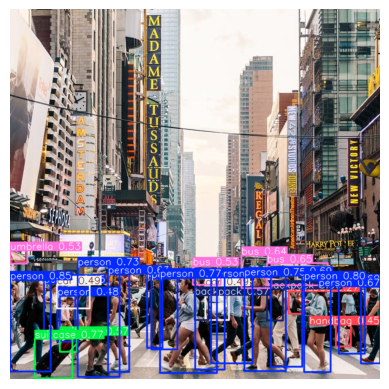

In [8]:
%matplotlib inline 
#this ensures matplotlib will display the plots right inside the notebook after executing the cell. 
plt.imshow(squeezedImg)
plt.axis('off')
plt.show()

### This function captures 4 random screenshots from a video and provides them to the model for evaluation.  
### It is used to demonstrate the performance of the model on real-time live video within a Jupyter Notebook.


In [9]:
from typing import List
from torch.nn import Module

def captureAndReturnVideo( test_indices:int , address:str, model:Module) -> List[int]  : 
    cap = cv2.VideoCapture(address)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)


    indices_list = np.random.uniform(1, int(total_frames), test_indices).astype('int')

    test_frame_count =0
    imageToShow = []
    
    while cap.isOpened(): 
        ret , frame = cap.read()
    
        if test_frame_count in indices_list : 
            screenShotResult = model(frame)
            imageToShow.append(np.squeeze(screenShotResult.render()))
    
        test_frame_count+=1
        if not ret: 
            print('video ended')
            break
        
        
        result = model(frame)
        cv2.imshow('testCase' , np.squeeze(result.render()))
    
        if cv2.waitKey(10) & 0xFF == ord('q'):
              break
        
    cap.release() 
    cv2.destroyAllWindows()
    return imageToShow



In [10]:
numberOfScreenShot = 4
address = 'traffic.mp4'
model = preTrainedModel 
imageToShow = captureAndReturnVideo(numberOfScreenShot , address , preTrainedModel)

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/alchemist-linux/Desktop/Object detection project/.venv/lib/python3.12/site-packages/cv2/qt/plugins"


video ended


### pretrained model performance on traffic cam 

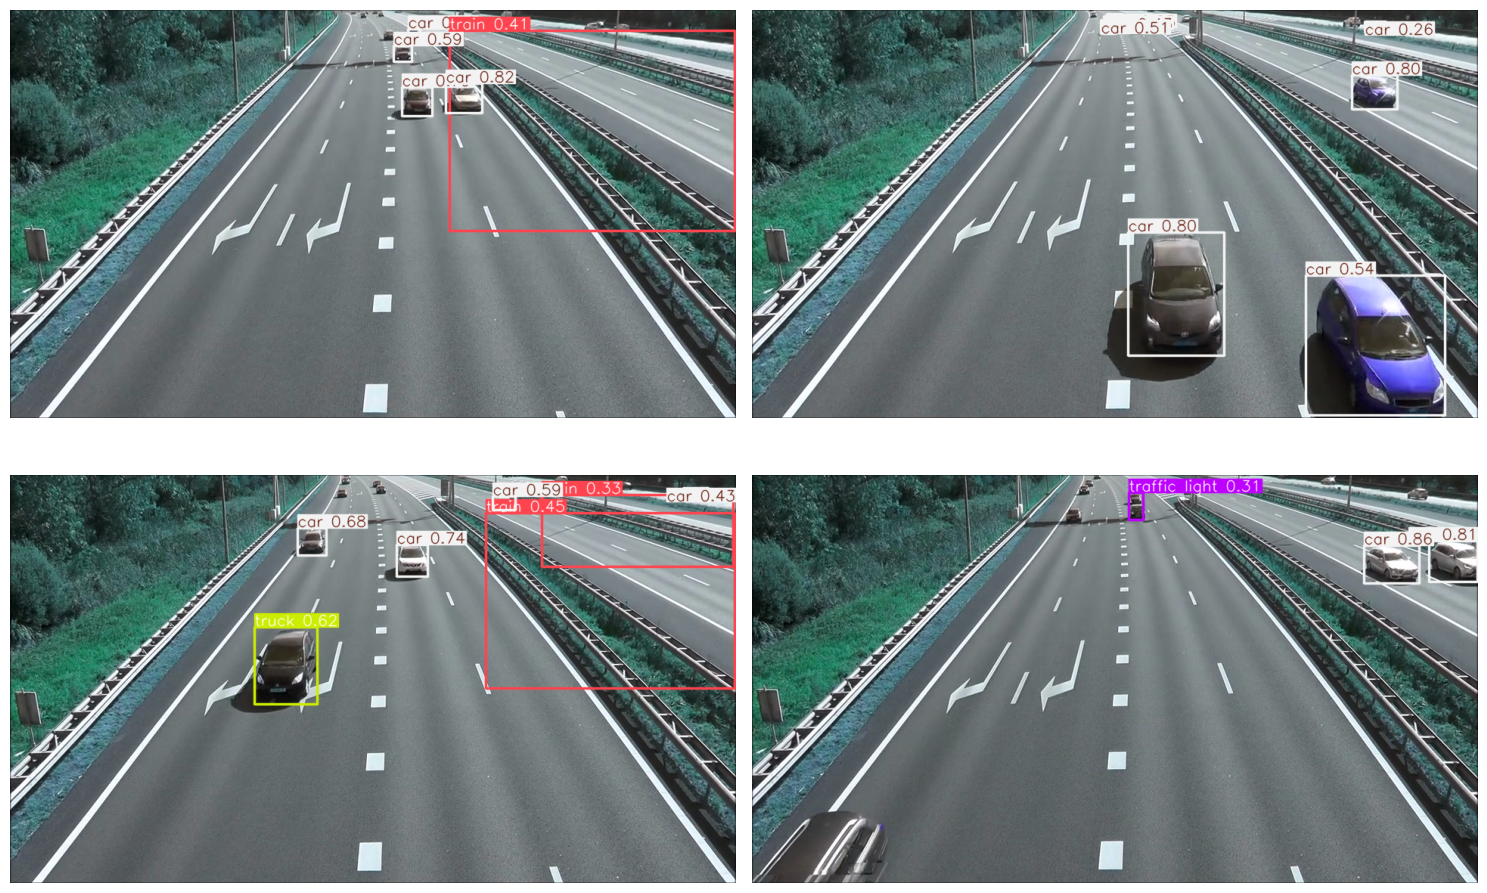

In [11]:
fig , axes = plt.subplots(2, 2 , figsize=(15 ,10))

for i, ax in enumerate(axes.flat):
    ax.imshow(imageToShow[i])
    #cv2.cvtColor(frameToShow[i], cv2.COLOR_BGR2RGB) # in case we need real time color
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# import kagglehub

# path = kagglehub.dataset_download("yasharjebraeily/drowsy-detection-dataset")
# print("Path to dataset files:", path)

### I added a dataset to improve my model's accuracy by providing more input, enabling it to detect images with lower or darker quality.  
### To achieve this, I renamed the repetitive file names to unique names to ensure the model could correctly match each image with its corresponding label text file.


In [11]:
import os
import uuid 

# Define paths
image_folders = ["data/awake", "data/drowsy"]
label_folder = "data/labels"

for folder in image_folders:
    prefix = os.path.basename(folder)  # Use folder name as prefix (awake or drowsy)
    for filename in os.listdir(folder):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            base_name, ext = os.path.splitext(filename)
            prefixList = base_name.split('_')
            new_name = f"{prefix}_{uuid.uuid4()}{ext}"
            
            # Rename image
            old_image_path = os.path.join(folder, filename)
            new_image_path = os.path.join(folder, new_name)
            os.rename(old_image_path, new_image_path)


#### I found a dataset where all images are square face images.  
#### To automate the labeling task, I generated a text file for each image, labeling the entire square image based on the folder it currently resides in.


In [ ]:
import os

data_dir = "data"  
output_dir = "./data/labels" 
os.makedirs(output_dir, exist_ok=True)

class_mapping = {
    "drowsy": 15, # in label image drowsy class is 15 and awake is 16
    "awake": 16
}

for class_name, class_id in class_mapping.items():
    class_folder = os.path.join(data_dir, class_name)
    
    if not os.path.exists(class_folder):
        print(f"Class folder not found: {class_folder}")
        continue
    
    for image_name in os.listdir(class_folder):
        if image_name.lower().endswith((".png", ".jpg", ".jpeg")):
            label_file_path = os.path.join(output_dir, os.path.splitext(image_name)[0] + ".txt")
            with open(label_file_path, "w") as f:
                x_center, y_center, width, height = 0.5, 0.5, 1.0, 1.0 # it centers and cover whole image
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
    
    print(f"Labels generated for class: {class_name}")

print("Auto-labeling complete!")


### In my YOLOv5 version, it seems all labels and images must be in the same folder to work.  
### To address this, I automated the task of transferring all images and their corresponding label files into a single `allFiles` folder.


In [60]:
import shutil

total_address = './data/allFiles'
awake_files = './data/awake'
drowsy_files = './data/drowsy'
labeled_files = './data/labels'

os.makedirs(total_address, exist_ok=True)

def moveFiles(source_dir, destination_dir): 
    for filename in os.listdir(source_dir): 
        source_path = os.path.join(source_dir , filename)
        destination_path = os.path.join(destination_dir , filename)

        if os.path.isfile(source_path):
            shutil.move(source_path ,destination_path )        


moveFiles(awake_files , total_address)
moveFiles(drowsy_files , total_address)
moveFiles(labeled_files , total_address)


### labeling our images to categorize them

!git clone https://github.com/tzutalin/labelImg

!pip install pyqt5 lxml --upgrade

!cd labelImg && pyrcc5 -o libs/resources.py resources.qrc

LabelImg is a graphical annotation tool for creating bounding boxes and labeling objects in images, essential for preparing datasets for object detection tasks. It supports formats like Pascal VOC (XML) and YOLO (TXT) for training models. Users manually draw boxes, assign labels, and save annotations for model training.


### training our data 

In [ ]:
!cd yolov5 && python train.py --img 512 --batch 64 --epochs 200 --data dataset.yml --weights yolov5s.pt --workers 6 

## > /dev/null 2>&1 i used this to remove logs that messes up my github presentation 

### I noticed that the model's output is returned as a CSV file.  
### Therefore, I decided to use Pandas to analyze the model's performance more effectively.


In [13]:
import pandas as pd

results_path = 'yolov5/runs/train/exp/results.csv'
df = pd.read_csv(results_path)

df.tail()

epoch     train/box_loss     train/obj_loss  \
195                195           0.020937           0.011674   
196                196           0.019909           0.012426   
197                197           0.018598           0.010544   
198                198           0.019701           0.012541   
199                199           0.020780           0.011192   

        train/cls_loss  metrics/precision  ...       val/obj_loss  \
195           0.003094            0.99205  ...           0.004208   
196           0.002502            0.99212  ...           0.004204   
197           0.003475            0.99206  ...           0.004139   
198           0.002912            0.99190  ...           0.004083   
199           0.002524            0.99177  ...           0.004058   

          val/cls_loss              x/lr0              x/lr1  \
195           0.001937           0.000397           0.000397   
196           0.001934           0.000347           0.000347   
197           0.001931           0.000298           0.000298   
198           0.001926           0.000249           0.000249   
199           0.001924           0.000199           0.000199   

                 x/lr2  
195           0.000397  
196           0.000347  
197           0.000298  
198           0.000249  
199           0.000199  

[5 rows x 14 columns]

In [14]:
model = torch.hub.load('ultralytics/yolov5' , 'custom' , path='yolov5/runs/train/exp/weights/last.pt')

Using cache found in /home/alchemist-linux/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-11 Python-3.12.3 torch-2.5.1+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


### testing the model

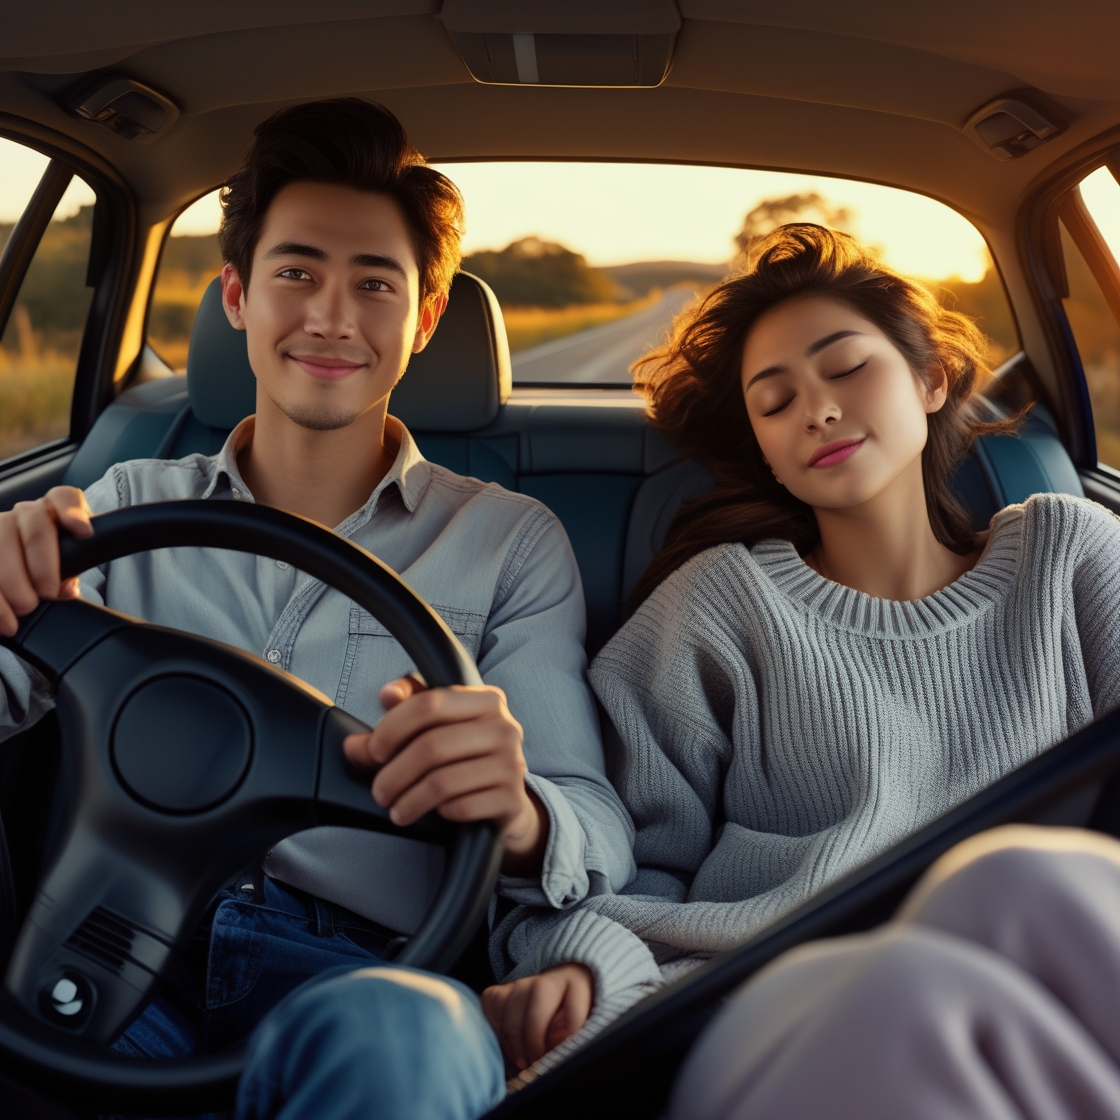

In [16]:
import os 
from IPython.display import Image 
testImage = os.path.join('testImage.png')
Image(testImage , width=500, height=500)

In [17]:
result = model(testImage)
result

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 1120x1120 1 drowsy, 1 awake
Speed: 24.7ms pre-process, 62.0ms inference, 0.4ms NMS per image at shape (1, 3, 640, 640)

(np.float64(-0.5), np.float64(1119.5), np.float64(1119.5), np.float64(-0.5))

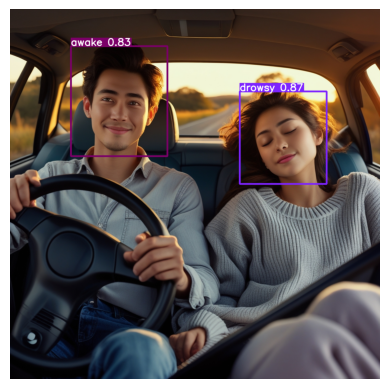

In [18]:
showResult = plt.imshow(np.squeeze(result.render()))
plt.axis('off')


### Let's test the model on a real-time video.

In [25]:
cap = cv2.VideoCapture('./test.mp4')

total_test_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
test_frame_indices = 4 
indices_list = np.random.uniform(1, int(total_test_frames), test_frame_indices).astype('int')
imageToShow = captureAndReturnVideo(test_frame_indices , 'test.mp4', model)

video ended


### The screenshots captured from the video demonstrate that the model can effectively distinguish and recognize drowsiness from alertness side by side.

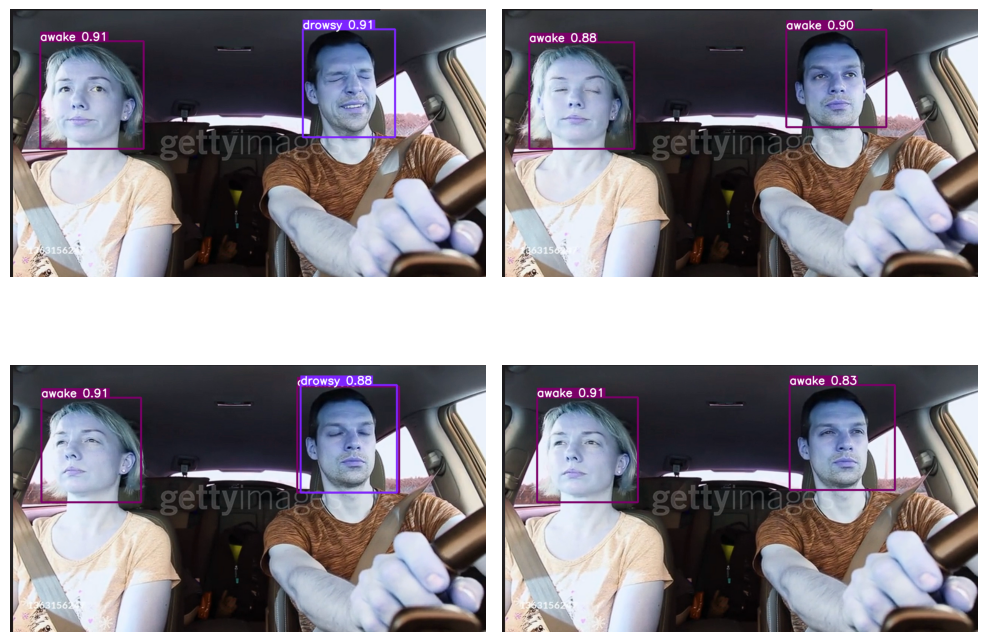

In [24]:
fig ,axes = plt.subplots(2, 2 , figsize=(10 ,10))

for i  ,axe in enumerate(axes.flat) : 
    axe.imshow(imageToShow[i])
    axe.axis('off')
    plt.tight_layout()

